In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [39]:
nat_gas = pd.read_csv("/Users/talhajamal/Desktop/Code/Python_Projects/JP Morgan - Quant (Forage)/data/Nat_Gas.csv")

In [40]:
nat_gas.head()
nat_gas.tail()

,Dates,Prices
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6
46,8/31/24,11.5
47,9/30/24,11.8


In [41]:
nat_gas.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [42]:
nat_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


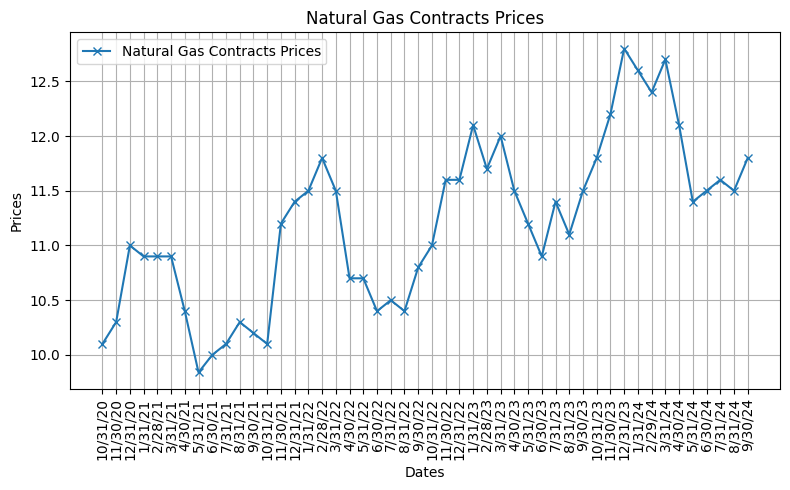

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(nat_gas['Dates'], nat_gas['Prices'], label='Natural Gas Contracts Prices', marker = 'x')
plt.title('Natural Gas Contracts Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The series seems to be trending upwards and might have a seasonality component to it. 

In [44]:
# Lets plot data for every year individually
nat_gas_separated = nat_gas.copy(deep=True)
nat_gas_separated['Dates'] = pd.to_datetime(nat_gas_separated['Dates'], format='%m/%d/%y')
nat_gas_separated['year'] = nat_gas_separated['Dates'].dt.year
nat_gas_separated['month'] = nat_gas_separated['Dates'].dt.month
nat_gas_separated.drop(['Dates'], axis=1, inplace=True)
nat_gas_separated = nat_gas_separated.pivot_table(index='month',  columns='year', values='Prices')

nat_gas_separated

year,2020,2021,2022,2023,2024
month,,,,,
1,NaN,10.90,11.5,12.1,12.6
2,NaN,10.90,11.8,11.7,12.4
3,NaN,10.90,11.5,12.0,12.7
4,NaN,10.40,10.7,11.5,12.1
5,NaN,9.84,10.7,11.2,11.4
6,NaN,10.00,10.4,10.9,11.5
7,NaN,10.10,10.5,11.4,11.6
8,NaN,10.30,10.4,11.1,11.5
9,NaN,10.20,10.8,11.5,11.8


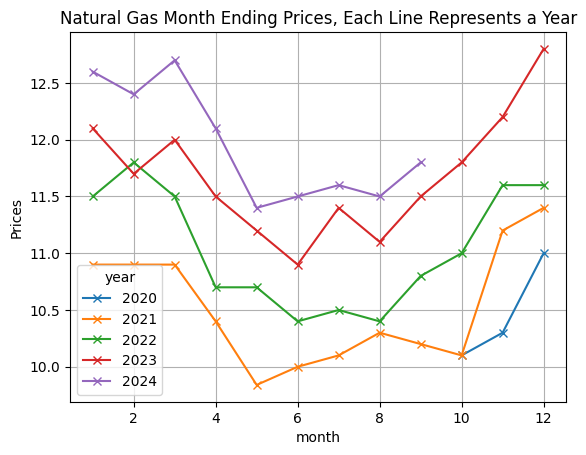

In [45]:
# Plot Data
nat_gas_separated.plot(marker = 'x')
plt.ylabel('Prices')
plt.title("Natural Gas Month Ending Prices, Each Line Represents a Year")
plt.grid(True)
plt.show()

Seasonality seems to be present within the data. During the Winter months the prices of natural gas contracts rise presumable due to higher demand for heating. The prices decrease during the summer presumable due to lower demand. 

In [46]:
# Prepare data 
nat_gas_linear = nat_gas.copy(deep=True)
nat_gas_linear['month'] = pd.DatetimeIndex(nat_gas_linear['Dates']).month

# One Hot Encoding of Monthly Data
nat_gas_linear = pd.get_dummies(nat_gas_linear, columns=['month'])
nat_gas_linear.head()

,Dates,Prices,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,10/31/20,10.1,False,False,False,False,False,False,False,False,False,True,False,False
1,11/30/20,10.3,False,False,False,False,False,False,False,False,False,False,True,False
2,12/31/20,11.0,False,False,False,False,False,False,False,False,False,False,False,True
3,1/31/21,10.9,True,False,False,False,False,False,False,False,False,False,False,False
4,2/28/21,10.9,False,True,False,False,False,False,False,False,False,False,False,False


## Prediction using SARIMA

In [47]:
nat_gas_linear['Dates'] = pd.to_datetime(nat_gas_linear['Dates'], format='%m/%d/%y')
train_data = nat_gas_linear[nat_gas_linear['Dates'] < '2023-10-31']
test_data = nat_gas_linear[nat_gas_linear['Dates'] >= '2023-10-31']

In [48]:
regression = LinearRegression().fit(train_data.iloc[:, 2:], train_data['Prices'])

In [49]:
nat_gas_predicted = regression.predict(test_data.iloc[:, 2:])
test_data['Predicted'] = nat_gas_predicted
print("Mean squared error: %.3f" % mean_squared_error(test_data['Prices'], nat_gas_predicted))

print("R squared: %.3f" % r2_score(test_data['Prices'], nat_gas_predicted))
test_data.head(2)

Mean squared error: 1.252
R squared: -4.389


,Dates,Prices,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Predicted
36,2023-10-31,11.8,False,False,False,False,False,False,False,False,False,True,False,False,10.406250
37,2023-11-30,12.2,False,False,False,False,False,False,False,False,False,False,True,False,11.023438


Clearly a Linear Model is not appropriate for our data. 

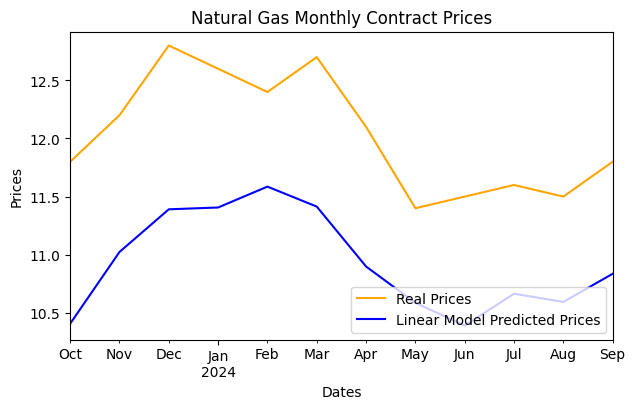

In [50]:
# Plotting predicted values and actual values
test_data.set_index('Dates', inplace=True)
plt.figure(figsize=(7, 4), dpi=100)

test_data['Prices'].plot(label='Real Prices', color='orange')
test_data['Predicted'].plot(label='Linear Model Predicted Prices', color='blue')

plt.title('Natural Gas Monthly Contract Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend(loc='lower right')

The Linear Model seems to follow the trend generally - but has a major shift in its predicted prices.